In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyclustering.cluster.kmedoids import kmedoids
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Scaffolds import MurckoScaffold
from scipy import stats
from umap import UMAP

sns.set_style("darkgrid",
              {"axes.facecolor": ".95",
               "axes.edgecolor": "#000000",
               "grid.color": "#EBEBE7",
               "font.family": "serif",
               "axes.labelcolor": "#000000",
               "xtick.color": "#000000",
               "ytick.color": "#000000",
               "grid.alpha": 0.4 })
sns.set_palette('muted')

/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experimental dataset

In [2]:
experimental_df = pd.read_csv('../../data/results_benchmark.csv')

scores = ['exp_dg', 'vina_score_blind', 'mmgbsa_score_blind']

## Basic statistics

In [3]:
# Quick look at data
print("Dataset shape:", experimental_df.shape)
print("\nColumn names:")
print(experimental_df.columns.tolist())
print("\nFirst few rows:")
print(experimental_df.head())

# Check for missing values
print("\nMissing values:")
print(experimental_df[scores].isnull().sum())

# Basic stats
print("\nStats (experimental dG, vina, mmgbsa):")
print(experimental_df[scores].describe())

Dataset shape: (25, 7)

Column names:
['name', 'smiles', 'exp_dg', 'exp_dg_error', 'vina_score_blind', 'mmgbsa_score_blind', 'mmgbsa_score_blind_sem']

First few rows:
     name                                             smiles    exp_dg  \
0  lig_27  [H]c1c(c(c(c(c1[H])[H])OC([H])([H])C([H])([H])... -6.116712   
1  lig_28  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -6.621838   
2  lig_30  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -7.853624   
3  lig_31  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -7.919932   
4  lig_32  [H]c1c(c(c2c(c1[H])C(=C(N2[H])C(=O)[O-])C([H])... -6.583362   

   exp_dg_error  vina_score_blind  mmgbsa_score_blind  mmgbsa_score_blind_sem  
0      0.120936            -9.158          -34.132755                0.688380  
1      0.027821            -9.659          -39.792497                0.408852  
2      0.188261            -9.501          -34.901277                0.493050  
3      0.028055           -10.423          -42.650132              

## Structure of numerical features

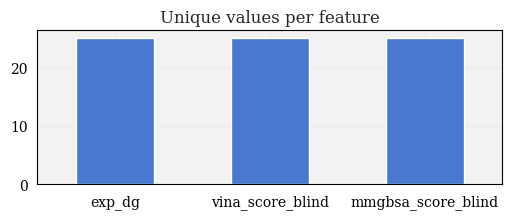

In [4]:
# Compute number of unique entries for each score type (exp_dg, vina, mmgbsa)
unique_values = experimental_df[scores].nunique().sort_values()

# Plot information
unique_values.plot.bar(figsize=(6, 2), rot=0, title="Unique values per feature");

# Computational dataset

## Basic stats

In [5]:
df = pd.read_csv('../../data/results.csv')

# Add molecular weight to DF
smiles = df['prot_smiles'].tolist()
mols = [Chem.MolFromSmiles(s) for s in smiles]
df['MW'] = [MolWt(m) for m in mols]

vars = ['vina_score', 'mmgbsa_score', 'MW']

In [6]:
# Quick look at data
print("Dataset shape:", df.shape)
print("\nFull dataframe column names:")
print(df.columns.tolist())
print("\nFirst few rows (scores_df):")
print(df[vars].head())

# Check for missing values
print("\nMissing values:")
print(df[vars].isnull().sum())

# Basic stats
print("\nStats (vina, mmgbsa):")
print(df[vars].describe())

Dataset shape: (59356, 9)

Full dataframe column names:
['name', 'orig_smiles', 'prot_smiles', 'mmgbsa_score', 'mmgbsa_score_sem', 'mmpbsa_score', 'mmpbsa_score_sem', 'vina_score', 'MW']

First few rows (scores_df):
   vina_score  mmgbsa_score       MW
0      -8.206    -54.684265  463.284
1      -9.915    -53.876397  442.353
2      -9.199    -53.526174  462.727
3      -8.151    -52.599412  512.198
4      -9.343    -52.518792  454.408

Missing values:
vina_score      0
mmgbsa_score    0
MW              0
dtype: int64

Stats (vina, mmgbsa):
         vina_score  mmgbsa_score            MW
count  59356.000000  59356.000000  59356.000000
mean      -8.348716    -30.718233    354.837185
std        0.923549      6.188770     67.704759
min      -11.909000    -54.684265    145.161000
25%       -9.096000    -34.814104    305.376250
50%       -8.257000    -31.103042    357.494000
75%       -7.633000    -27.031946    405.296000
max       -5.257000      3.037913    687.497000


Number of unique values: vina_score       4546
MW              13420
mmgbsa_score    59356
dtype: int64


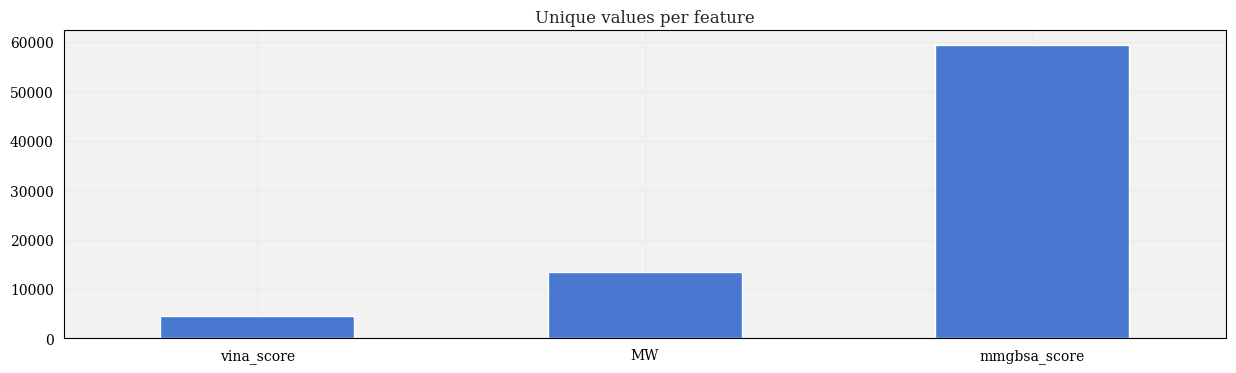

In [7]:
# Compute number of unique entries for each score type (exp_dg, vina, mmgbsa)
unique_values = df[vars].nunique().sort_values()

print("Number of unique values:", unique_values)

# Plot information
unique_values.plot.bar(figsize=(15, 4), rot=0, title="Unique values per feature");

## Visualizing the distributions

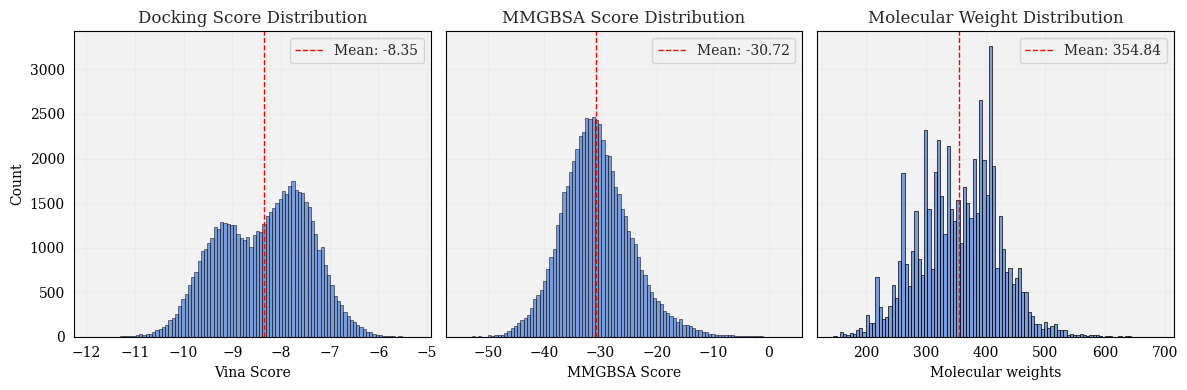

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Vina distribution
axes[0].hist(df['vina_score'], bins=100, edgecolor='black', linewidth=.5, alpha=0.7)
axes[0].set_xlabel('Vina Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Docking Score Distribution')
axes[0].axvline(df['vina_score'].mean(), color='red', linestyle='--', lw=1, label=f'Mean: {df["vina_score"].mean():.2f}')
axes[0].legend()

# MMGBSA distribution
axes[1].hist(df['mmgbsa_score'], bins=100, edgecolor='black', linewidth=.5, alpha=0.7)
axes[1].set_xlabel('MMGBSA Score')
# axes[1].set_ylabel('Count')
axes[1].set_title('MMGBSA Score Distribution')
axes[1].axvline(df['mmgbsa_score'].mean(), color='red', linestyle='--', lw=1, label=f'Mean: {df["mmgbsa_score"].mean():.2f}')
axes[1].legend()

# Molecular weight distribution
axes[2] = sns.histplot(df['MW'], bins=100, edgecolor='black', linewidth=.5, alpha=0.7)
axes[2].set_xlabel('Molecular weights')
# axes[2].set_ylabel('Count')
axes[2].set_title('Molecular Weight Distribution')
axes[2].axvline(df['MW'].mean(), color='red', linestyle='--', lw=1, label=f"Mean: {df['MW'].mean():.2f}")
axes[2].legend()

plt.tight_layout()
plt.show()

## Analyzing molecular structures

In [9]:
def get_scaffold(smiles):
    """Extract Bemis-Murcko scaffold from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

In [10]:
# Extract scaffolds for all molecules
print("Extracting scaffolds from SMILES...")
df['scaffold'] = df['prot_smiles'].apply(get_scaffold)

scaffold_counts = Counter(df['scaffold'])
print(f"\nNumber of unique scaffolds:", len(scaffold_counts))
print(f"\nTop 10 most common scaffolds:")
for scaffold, count in scaffold_counts.most_common(10):
    print(f"{count:5d} molecules: {scaffold[:30]}...")

Extracting scaffolds from SMILES...

Number of unique scaffolds: 4326

Top 10 most common scaffolds:
16388 molecules: c1ccc2[nH]ccc2c1...
 8126 molecules: O=C(CCc1c[nH]c2ccccc12)Oc1cccc...
 2630 molecules: O=C(CCc1c[nH]c2ccccc12)OC1CCCC...
 1179 molecules: O=C(CCc1cc[nH]c1)Oc1ccccc1...
  930 molecules: O=C(CCc1c(-c2ccccc2)[nH]c2cccc...
  830 molecules: O=C(OCc1ccccc1)c1cc2ccccc2[nH]...
  734 molecules: O=C(CCc1c(-c2ccccc2)[nH]c2cccc...
  673 molecules: O=C(COc1ccccc1)C(=O)c1c[nH]c2c...
  522 molecules: O=C(CCc1cc[nH]c1)OC1CCCCC1...
  505 molecules: O=C(COc1ccccc1)CC12CC3CC(CC(C3...


I'm going to visualize the top 5 most common scaffolds, along with the *query molecule*, i.e., the molecule that was used as the seed for screening. 

['Query molecule\nVina: -9.74, MMGBSA: -49.39472712857148', 'Scaffold #1\n(count: 16388)', 'Scaffold #2\n(count: 8126)', 'Scaffold #3\n(count: 2630)', 'Scaffold #4\n(count: 1179)', 'Scaffold #5\n(count: 930)']


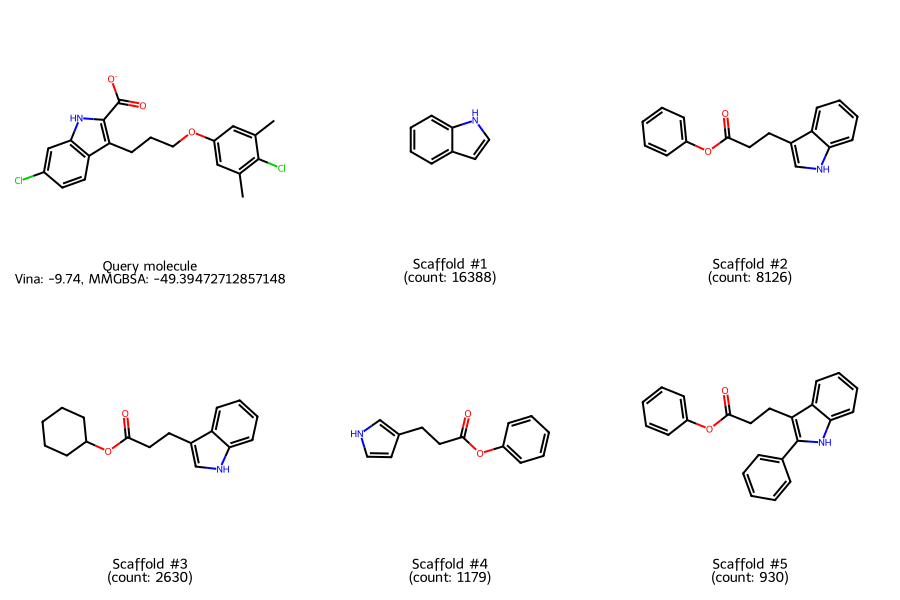

In [11]:
mols_to_draw = []
legends = []

# Get seed molecule from experimental dataset - this is molecule with best binding affinity
best_mol_idx = experimental_df['exp_dg'].idxmin()
query_molecule = experimental_df.loc[best_mol_idx]
query_mol = Chem.MolFromSmiles(query_molecule['smiles'])
mols_to_draw.append(query_mol)
legends.append(f"Query molecule\nVina: {query_molecule['vina_score_blind']}, MMGBSA: {query_molecule['mmgbsa_score_blind']}")

# Get 5 most common scaffolds
top_5_scaffolds = [scaffold for scaffold, _ in scaffold_counts.most_common(5)]
for i, scaffold_smiles in enumerate(top_5_scaffolds, 1):
    scaffold_mol = Chem.MolFromSmiles(scaffold_smiles)
    mols_to_draw.append(scaffold_mol)
    count = scaffold_counts[scaffold_smiles]
    legends.append(f"Scaffold #{i}\n(count: {count})")

print(legends)

img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=3, subImgSize=(300, 300), legends=legends, returnPNG=False)
display(img)

How much of the dataset do these scaffolds account for?

In [12]:
sum(sorted(scaffold_counts.values(), reverse=True)[:5]) / len(df)

0.4928398140036391

## Clustering

Now I'll do clustering based on structural similarity. To do so, I'll use the `pyclustering` module. This involves choosing initial values for the $k$ medoids, for which I'll choose different scaffolds that are far apart.

In [13]:
# Compute Morgan fingerprints of unique scaffolds
fp_gen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

unique_scaffolds = df['scaffold'].unique()
scaffold_mols = [Chem.MolFromSmiles(smiles) for smiles in unique_scaffolds]
scaffold_fps = [fp_gen.GetCountFingerprint(mol) for mol in scaffold_mols]


# Compute pariwise Tanimoto similarities / distances
n_scaffolds = len(unique_scaffolds)
similarity_matrix = np.zeros((n_scaffolds, n_scaffolds))

for i in range(n_scaffolds):
    similarities = DataStructs.BulkTanimotoSimilarity(scaffold_fps[i], scaffold_fps)
    similarity_matrix[i] = similarities

distance_matrix = 1 - similarity_matrix

In [14]:
def select_initial_medoids(distance_matrix, n_clusters, random_state=42):
    """Select initial medoids using maximin strategy (spread them out)"""
    np.random.seed(random_state)
    n_samples = distance_matrix.shape[0]

    # Start with a random point
    medoids = [np.random.randint(n_samples)]

    # Add points that are farthest from current medoids
    for _ in range(n_clusters - 1):
        # For each point, find distance to nearest medoid
        distances_to_medoids = distance_matrix[:, medoids].min(axis=1)
        # Add the point that's farthest from any medoid
        next_medoid = np.argmax(distances_to_medoids)
        medoids.append(next_medoid)
    
    return medoids

In [15]:
# Perform clustering
n_clusters = 12
initial_medoids = select_initial_medoids(distance_matrix, n_clusters)

kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

clusters = kmedoids_instance.get_clusters()
medoid_indices = kmedoids_instance.get_medoids()

print(f"Medoid indices: {medoid_indices}")
print(f"Number of clusters: {len(clusters)}")
print(f"\nCluster sizes:")
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i}: {len(cluster)} scaffolds")

Medoid indices: [66, 11, 148, 0, 2547, 407, 55, 122, 589, 1857, 1005, 327]
Number of clusters: 12

Cluster sizes:
  Cluster 0: 471 scaffolds
  Cluster 1: 535 scaffolds
  Cluster 2: 209 scaffolds
  Cluster 3: 432 scaffolds
  Cluster 4: 180 scaffolds
  Cluster 5: 370 scaffolds
  Cluster 6: 405 scaffolds
  Cluster 7: 776 scaffolds
  Cluster 8: 175 scaffolds
  Cluster 9: 179 scaffolds
  Cluster 10: 337 scaffolds
  Cluster 11: 257 scaffolds


In [16]:
# Assign cluster labels to scaffolds
labels = np.zeros(len(unique_scaffolds), dtype=int)
for cluster_id, cluster_members in enumerate(clusters):
    for member_idx in cluster_members:
        labels[member_idx] = cluster_id

# Assign cluster labels to molecules
scaffold_to_cluster = dict(zip(unique_scaffolds, labels))
df['cluster'] = df['scaffold'].map(scaffold_to_cluster)

print(f"Molecules per cluster:")
print(df['cluster'].value_counts().sort_index())

Molecules per cluster:
cluster
0      1780
1      8662
2      1548
3      4226
4       870
5      2970
6     15536
7      2807
8       779
9     16817
10     2292
11     1069
Name: count, dtype: int64


## Visualizing clusters w/ UMAP

Here, I'll perform UMAP on the molecular fingerprints to look at three things:

1. How distinct the clusters are (for this, I'll do UMAP and color the points based on cluster)
2. How much clusters correspond to docking scores (coloring by docking scores)
3. How much clusters correspond to MMGBSA scores (coloring by MMGBSA scores)

This is ultimately to better understand what information the models are using to predict docking scores and MMGBSA scores. I expect that the docking scores largely depend on molecular structure and molecular weight. We already saw that the two distributions share the same biomodal shape. So, I expect that docking scores can be predicted reasonably well by scaffold. That is, docking scores largely depend on the structure of the molecule.

I expect that, since MMGBSA has proven to be harder to learn, then predicting this from structure alone is difficult for current ML models. So, I expect that the MMGBSA scores will not correspond as closely to the structural clusters as do the docking scores. This would indicate that the MD simulations capture more nuanced information than just molecular structure. Thus, when we train models to predict MMGBSA scores from molecular structure alone, they struggle.

### Run UMAP

In [17]:
# Compute ECFP4 fingerprints:
def smiles_to_fp(smiles):
    # Return fingerprint as numpy array
    mol = Chem.MolFromSmiles(smiles)
    fp_gen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    return fp_gen.GetCountFingerprintAsNumPy(mol)

df['fps'] = df['prot_smiles'].apply(smiles_to_fp)

In [18]:
# Run UMAP
umap_model = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='jaccard',
    random_state=42,
    verbose=True
)

fp_array = np.vstack(df['fps'].values)
umap_coords = umap_model.fit_transform(fp_array)

/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='jaccard', n_jobs=1, random_state=42, verbose=True)
Tue Oct  7 11:31:40 2025 Construct fuzzy simplicial set
Tue Oct  7 11:31:40 2025 Finding Nearest Neighbors
Tue Oct  7 11:31:41 2025 Building RP forest with 17 trees
Tue Oct  7 11:32:07 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Tue Oct  7 11:32:39 2025 Finished Nearest Neighbor Search
Tue Oct  7 11:32:45 2025 Construct embedding


/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/wvir/miniconda3/envs/mfal/lib/python3.11/site-packages/umap/spectral.py:548: UserWarn

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         23/200 [00:03]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [00:06]

	completed  40  /  200 epochs


Epochs completed:  31%| ███        62/200 [00:09]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      83/200 [00:12]

	completed  80  /  200 epochs


Epochs completed:  51%| █████      102/200 [00:15]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    123/200 [00:19]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   143/200 [00:22]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  163/200 [00:25]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [00:28]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:31]


Tue Oct  7 11:34:24 2025 Finished embedding


In [19]:
df['umap_x'] = umap_coords[:, 0]
df['umap_y'] = umap_coords[:, 1]

In [20]:
df.to_csv("data_complete.csv")

### Visualize

The original clustering with K-Medoids didn't work so well, so I'm going to try just visualizing the clusters colored by the top few scaffolds.

In [33]:
N = 5   # number of top scaffolds to color, we'll color the rest gray

top_N_scaffolds = [scaffold for scaffold, _ in scaffold_counts.most_common(N)]
total_top_N = sum(scaffold_counts[s] for s in top_N_scaffolds)
coverage = 100 * total_top_N / len(df)
print(f"coverage: {coverage}")

# Assign scaffold groups
def assign_scaffold_group(scaffold):
    if scaffold in top_N_scaffolds:
        return top_N_scaffolds.index(scaffold)
    else:
        return -1
    
df['scaffold_group'] = df['scaffold'].apply(assign_scaffold_group)

coverage: 49.283981400363906


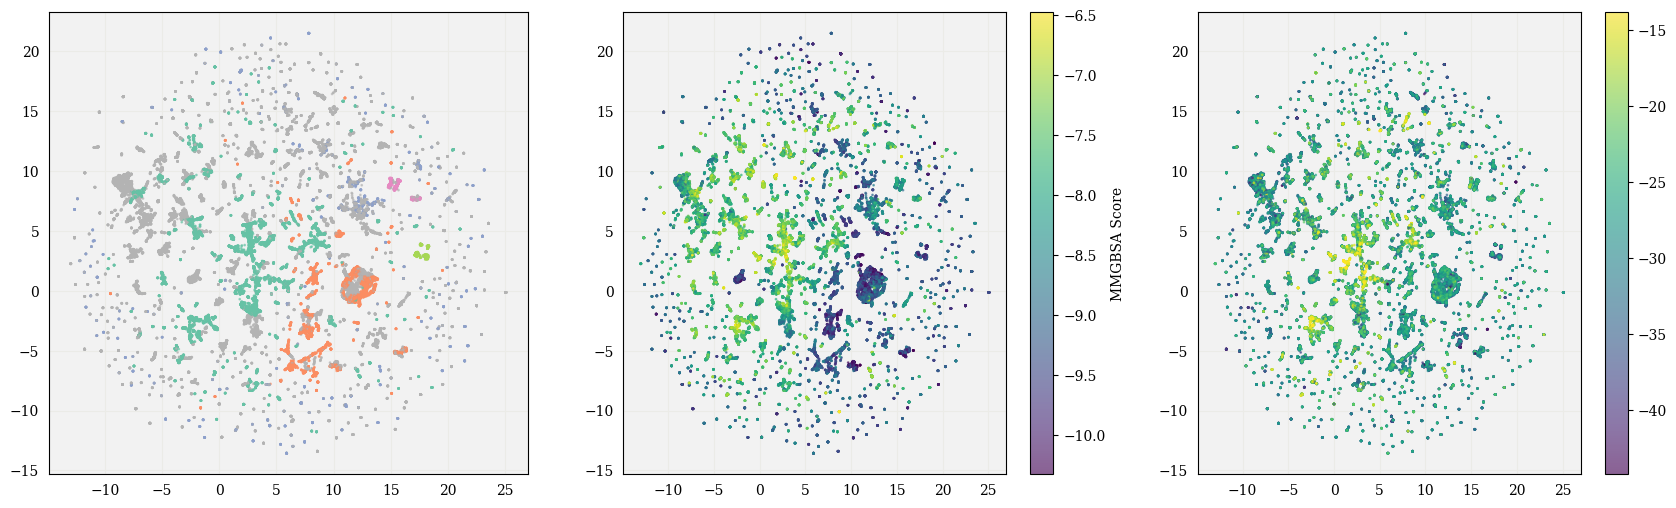

In [37]:
from matplotlib.colors import ListedColormap

distinct_colors = sns.color_palette('Set2', 5)  # distinct colors for top 5 clusters
colors = distinct_colors + [(0.7, 0.7, 0.7)]    # gray for clusters not in top 5
cmap = ListedColormap(colors)

df['scaffold_group_viz'] = df['scaffold_group'].apply(
    lambda x: x if x >= 0 else N
)

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

scatter1 = axes[0].scatter(
    df['umap_x'],
    df['umap_y'],
    c=df['scaffold_group_viz'],
    cmap=cmap,
    s=1,
    alpha=0.6,
    vmin=0,
    vmax=N
)

scatter2 = axes[1].scatter(
    df['umap_x'],
    df['umap_y'],
    c=df['vina_score'],
    cmap='viridis',
    s=1,
    alpha=0.6,
    vmin=df['vina_score'].quantile(.01),
    vmax=df['vina_score'].quantile(.99)
)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Vina Score', fontsize=10)

scatter3 = axes[2].scatter(
    df['umap_x'],
    df['umap_y'],
    c=df['mmgbsa_score'],
    cmap='viridis',
    s=1,
    alpha=0.6,
    vmin=df['mmgbsa_score'].quantile(.01),
    vmax=df['mmgbsa_score'].quantile(.99)
)
cbar3 = plt.colorbar(scatter3, ax=axes[2])
cbar2.set_label('MMGBSA Score', fontsize=10)

In [28]:
from matplotlib.colors import ListedColormap

# Create color map for cluster visualization
cluster_counts = df['cluster'].value_counts()
top_5_clusters = cluster_counts.head(5).index.tolist()

df['cluster_viz'] = df['cluster'].apply(
    lambda x: x if x in top_5_clusters else -1
)

distinct_colors = sns.color_palette('Set2', 5)  # distinct colors for top 5 clusters
colors = distinct_colors + [(0.7, 0.7, 0.7)]    # gray for clusters not in top 5
cmap = ListedColormap(colors)

# Remap cluster_viz so it's contiguous (0-5 instead of scattered IDs)
cluster_mapping = {cluster_id: i for i, cluster_id in enumerate(top_5_clusters)}
cluster_mapping[-1] = 5  # "Other" → 5
df['cluster_viz'] = df['cluster_viz'].map(cluster_mapping)

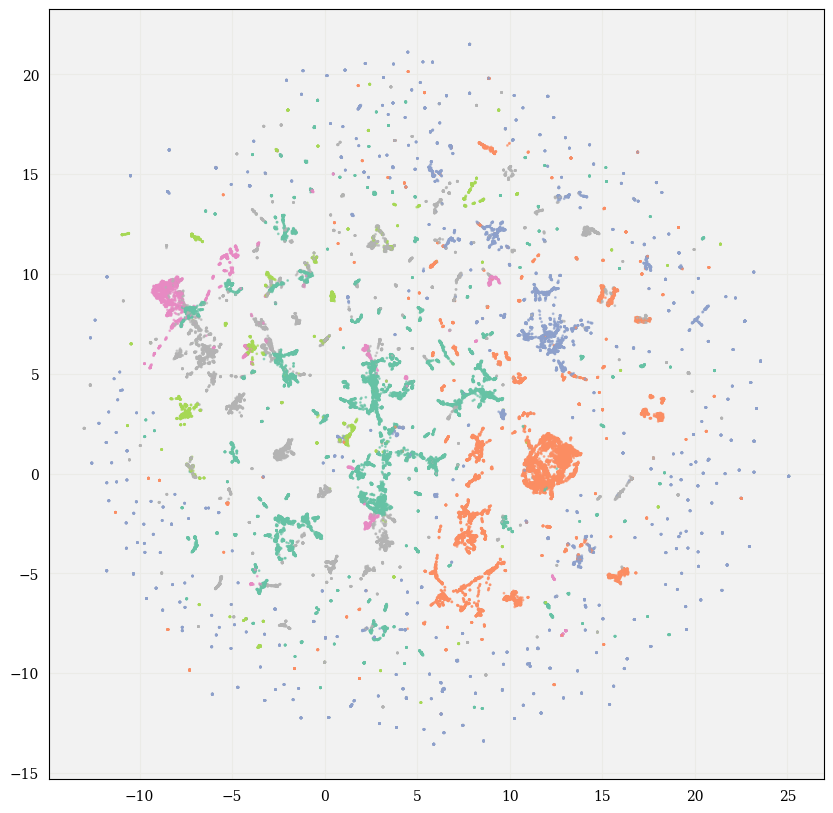

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df['umap_x'],
    df['umap_y'],
    c=df['cluster_viz'],
    cmap=cmap,
    s=1,
    alpha=0.6
)